In [1]:
from Parser import parse_frames, get_video_joint_angles
from scipy.signal import medfilt
from Functions import find_extremas, detect_side, analyse_each_rep
from JointAngles import JointAngles
import numpy as np
import math
import glob
import os
import itertools
import pickle
import matplotlib.pyplot as plt

# Need a folder with npy compressed files of videos


Starting...
Keypoints from folder: output_points_bicep_correct3
Detected arm: left
Starting...
Keypoints from folder: output_points_bicep_side
Detected arm: left
Starting...
Keypoints from folder: output_points_bicep_side5


C:\Users\altaok\Documents\GitHub\IndividualProject\JointAngles.py:90: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)


Detected arm: left
Largest angles between upper arm and trunk: [113.93488663 115.42387059 110.50122074 110.33623667]
Largest angles between trunk and knee: [132.79083103 134.92471428 135.56020957 136.71005813]
Number of maxima points between Upper Arm and Forearm: 0
[]
Number of reps performed: 2
[81.51624942 89.13707503]


C:\Users\altaok\Documents\GitHub\IndividualProject\Functions.py:72: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
C:\Users\altaok\Documents\GitHub\IndividualProject\Functions.py:73: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)
C:\Users\altaok\Documents\GitHub\IndividualProject\Functions.py:72: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
C:\Users\altaok\Documents\GitHub\IndividualProject\Functions.py:73: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)


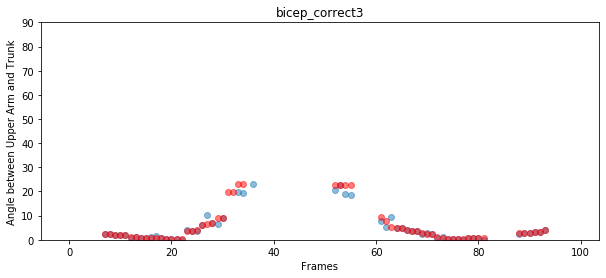

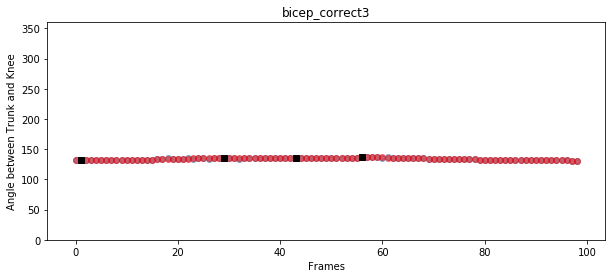

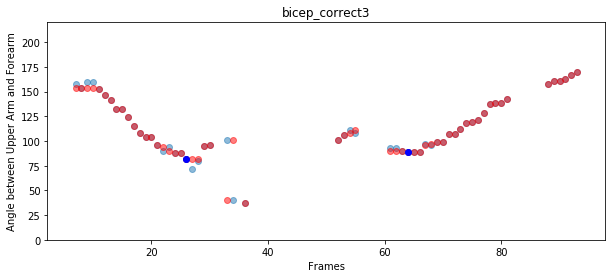

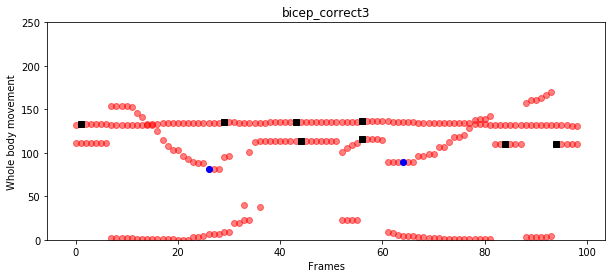



Largest angles between upper arm and trunk: [103.02273901 106.00507576 107.94793045 104.23174496 104.29058462
 104.97430477 104.22364391 106.59878435 107.05583089]
Largest angles between trunk and knee: [0.85581923 5.61694733 6.37315622 4.27067489 5.97849435 6.06254363
 5.69323515 5.21455142 4.92021696 1.1742648  5.02607239 5.84126828
 6.74704125 7.76289379 5.64539281]
Number of maxima points between Upper Arm and Forearm: 3
[105.19545497  97.62124572  96.84104519]
Number of reps performed: 1
[99.58515658]


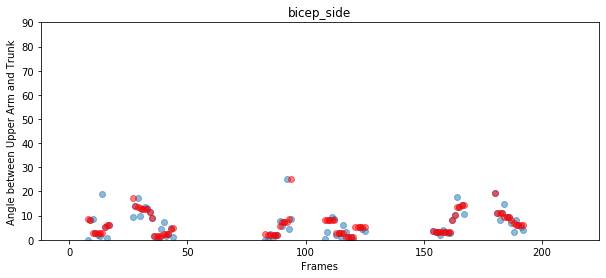

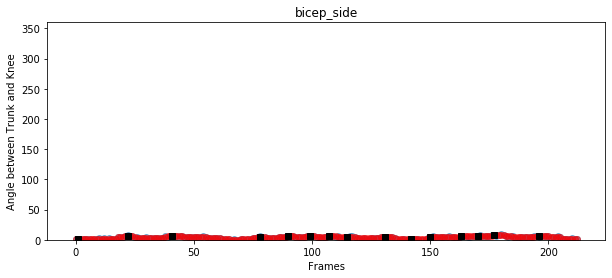

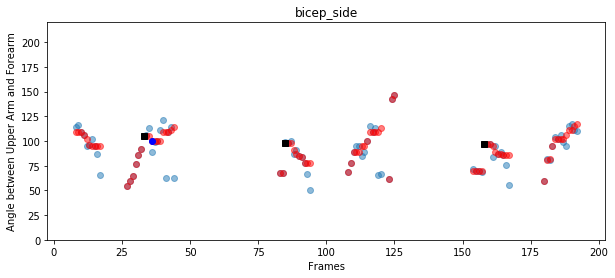

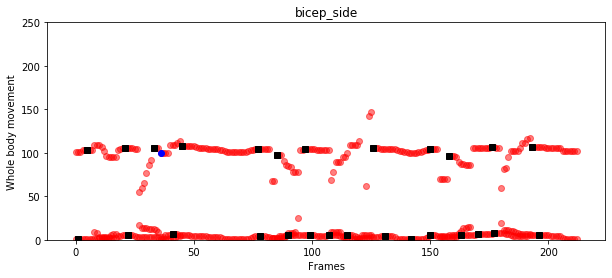

Repetition: 1
Minimum angle between upper arm and forearm: nan
Maximum angle between upper arm and trunk: 106.00507576471512
Maximum angle between trunk and knee: 5.616947330313349


Repetition: 2
Minimum angle between upper arm and forearm: nan
Maximum angle between upper arm and trunk: 107.94793044822126
Maximum angle between trunk and knee: 6.373156217773944


Repetition: 3
Minimum angle between upper arm and forearm: nan
Maximum angle between upper arm and trunk: 104.97430477084906
Maximum angle between trunk and knee: 6.062543631391894


Repetition: 4
Minimum angle between upper arm and forearm: nan
Maximum angle between upper arm and trunk: 107.05583089295392
Maximum angle between trunk and knee: 7.762893786401263


Largest angles between upper arm and trunk: [103.02137247 105.28613756   3.17024028 107.92005589 104.22377686
 104.34700846 103.60570308   3.5006447  104.86367356 104.05038747
 106.41273559 107.04696409 103.11046508 105.28624919 106.2945258
 104.78035861 107.11135694 

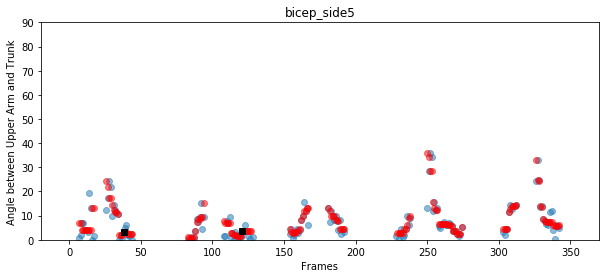

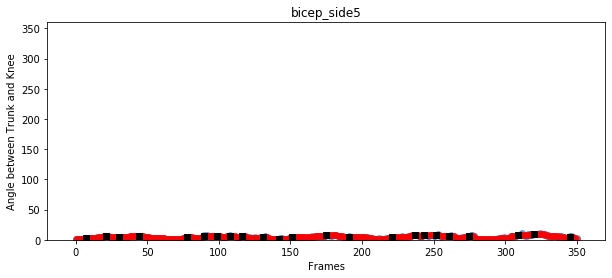

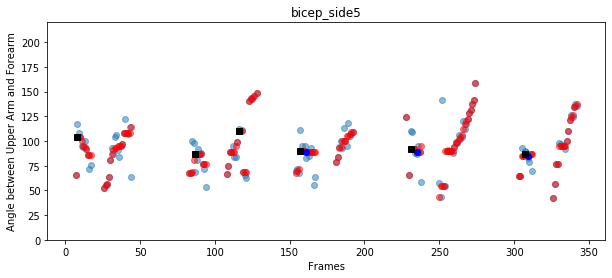

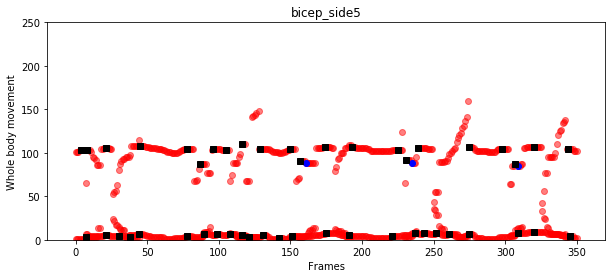

Repetition: 1
Minimum angle between upper arm and forearm: nan
Maximum angle between upper arm and trunk: 103.02137247064394
Maximum angle between trunk and knee: 3.3981577665117855


Repetition: 2
Minimum angle between upper arm and forearm: nan
Maximum angle between upper arm and trunk: 107.92005589340096
Maximum angle between trunk and knee: 6.399225463583521


Repetition: 3
Minimum angle between upper arm and forearm: nan
Maximum angle between upper arm and trunk: 104.34700845554637
Maximum angle between trunk and knee: 6.439928946411063


Repetition: 4
Minimum angle between upper arm and forearm: nan
Maximum angle between upper arm and trunk: 104.86367356346511
Maximum angle between trunk and knee: 5.280330710989761


Repetition: 5
Minimum angle between upper arm and forearm: nan
Maximum angle between upper arm and trunk: 107.0469640908301
Maximum angle between trunk and knee: 7.737076929461978


Repetition: 6
Minimum angle between upper arm and forearm: nan
Maximum angle between 

In [2]:
# modify this path for other videos 
# input_folder = "/home/aleko/Documents/Projects/IndividualProject/bicepvid"
input_folder = "C:\\Users\\altaok\\Documents\\GitHub\\IndividualProject\\keypoints_for_all"
folder_paths = glob.glob(os.path.join(input_folder, 'output_points_bicep*'))     

video_joint_angles = get_video_joint_angles(folder_paths, 'bicep curl')
    
# contains jointAngle objects where all angles for each video are stored
for obj in video_joint_angles:
    video_name = obj.video_name
    upArm_trunk_angles = np.array(obj.upArm_trunk_angles)
    upArm_trunk_angles_filtered = medfilt(medfilt(upArm_trunk_angles, 5), 5)
   
    upArm_forearm_angles = np.array(obj.upArm_forearm_angles)
    upArm_forearm_angles_filtered = medfilt(medfilt(upArm_forearm_angles, 5), 5)
    
    trunk_knee_angles = np.array(obj.trunk_knee_angles)
    trunk_knee_angles_filtered = medfilt(medfilt(trunk_knee_angles, 5), 5)
    
    # Find upper arm and trunk maximum angles to detect wrong form 
    upArm_trunk_maximas, indexesmax1 = find_extremas(upArm_trunk_angles_filtered)
    print("Largest angles between upper arm and trunk: " + str(upArm_trunk_maximas))

    # Find trunk and knee maximum angles to detect wrong form 
    trunk_knee_maximas, indexesmax2 = find_extremas(trunk_knee_angles_filtered)
    print("Largest angles between trunk and knee: " + str(trunk_knee_maximas))

    # Count repetitions
    upArm_forearm_maximas, indexesmax3 = find_extremas(upArm_forearm_angles_filtered)    
    print("Number of maxima points between Upper Arm and Forearm: " + str(upArm_forearm_maximas.size))
    print(upArm_forearm_maximas)


    # Find upper arm and forearm minimum points to count reps 
    upArm_forearm_minimas, indexesmin = find_extremas(upArm_forearm_angles_filtered, maxima=False)
    print("Number of reps performed: " + str(upArm_forearm_minimas.size))
    print(upArm_forearm_minimas)

   
    # Plot 1
    plt.figure(figsize=(10,4))
    plt.scatter(np.arange(upArm_trunk_angles.shape[0]), upArm_trunk_angles, alpha=0.5)
    plt.scatter(np.arange(upArm_trunk_angles_filtered.shape[0]), upArm_trunk_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Upper Arm and Trunk')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,90)
    
    # Annontate maxima points
    plt.plot(indexesmax1, upArm_trunk_angles_filtered[indexesmax1], 'ks')
    plt.show()
    
    # Plot 2
    plt.figure(figsize=(10,4))
    plt.scatter(np.arange(trunk_knee_angles.shape[0]), trunk_knee_angles, alpha=0.5)
    plt.scatter(np.arange(trunk_knee_angles_filtered.shape[0]), trunk_knee_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Trunk and Knee')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,360)
    
    # Annontate maxima points
    plt.plot(indexesmax2, trunk_knee_angles_filtered[indexesmax2], 'ks')
    plt.show()

    # Plot 3
    plt.figure(figsize=(10,4))
    plt.scatter(np.arange(upArm_forearm_angles.shape[0]), upArm_forearm_angles, alpha=0.5)
    plt.scatter(np.arange(upArm_forearm_angles_filtered.shape[0]), upArm_forearm_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Upper Arm and Forearm')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,220) 
    
    # Annotate minima apoints on the graph   
    max_points = upArm_forearm_angles_filtered[indexesmax3]
    min_points = upArm_forearm_angles_filtered[indexesmin]
    plt.plot(indexesmin, min_points, 'bo')
    plt.plot(indexesmax3, max_points, 'ks')

    """
        # Annotate local maximas
        for maxp, indx in zip(max_points, indexesmax3):
            plt.annotate('local max', xy=(indx, maxp), xytext=(indx, maxp+25),
                    arrowprops=dict(facecolor='black', shrink=0.05))

        # Annotate local minimas
        for minp, indx in zip(min_points, indexesmin):
            plt.annotate('local min', xy=(indx, minp), xytext=(indx, minp-35),
                    arrowprops=dict(facecolor='black', shrink=0.05))     
    """
    plt.show()

    # Plot 4
    plt.figure(figsize=(10,4))
    plt.scatter(np.arange(upArm_forearm_angles_filtered.shape[0]), upArm_forearm_angles_filtered, c='r', alpha=0.5)
    plt.scatter(np.arange(upArm_trunk_angles_filtered.shape[0]), upArm_trunk_angles_filtered, c='r', alpha=0.5)
    plt.scatter(np.arange(trunk_knee_angles_filtered.shape[0]), trunk_knee_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Whole body movement')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,250) 
    # Annotate minima apoints      
    plt.plot(indexesmin, upArm_forearm_angles_filtered[indexesmin], 'bo')
    plt.plot(indexesmax1, upArm_trunk_angles_filtered[indexesmax1], 'ks')
    plt.plot(indexesmax2, trunk_knee_angles_filtered[indexesmax2], 'ks')
    plt.plot(indexesmax3, upArm_forearm_angles_filtered[indexesmax3], 'ks')
    
    plt.show()
   
    
    # Each rep analysis
    # local minimums for upper arm and forearm are min angles in each rep
    analyse_each_rep(trunk_knee_angles_filtered, upArm_forearm_angles_filtered, upArm_trunk_angles_filtered, upArm_forearm_maximas)

    print('\n' + '='*120 + '\n')

In [8]:
a = np.array([[1,2],[1,2]])
b = np.array([[4,5], [4,5]])
c = np.append(a, b)
print(c)

[1 2 1 2 4 5 4 5]


In [6]:
a = [[1,2],[3,4]]
a = np.array(a)
print(a)


[[1 2]
 [3 4]]
